# Phishing Detection 

[Tarun Tiwari](https://www.kaggle.com/taruntiwarihp/phishing-site-urls)

In [1]:
pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d taruntiwarihp/phishing-site-urls

 55% 5.00M/9.03M [00:00<00:00, 21.9MB/s]
100% 9.03M/9.03M [00:00<00:00, 35.9MB/s]


In [35]:
!kaggle datasets download -d aashita/masks

  0% 0.00/2.10M [00:00<?, ?B/s]
100% 2.10M/2.10M [00:00<00:00, 145MB/s]


In [4]:
pip install selenium

     |████████████████████████████████| 954 kB 14.4 MB/s 
     |████████████████████████████████| 356 kB 72.1 MB/s 
     |████████████████████████████████| 138 kB 79.7 MB/s 
     |████████████████████████████████| 3.5 MB 79.8 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Import Modules

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer 

from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB 

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image 

from selenium import webdriver
from bs4 import BeautifulSoup
import networkx as nx

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
import pickle
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## Preparing Dataset

In [11]:
!unzip /content/phishing-site-urls.zip

Archive:  /content/phishing-site-urls.zip
replace phishing_site_urls.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: phishing_site_urls.csv  


In [36]:
!unzip /content/masks.zip

Archive:  /content/masks.zip
  inflating: comment.png             
  inflating: loc.png                 
  inflating: masks-wordclouds/comment.png  
  inflating: masks-wordclouds/loc.png  
  inflating: masks-wordclouds/star.png  
  inflating: masks-wordclouds/upvote.png  
  inflating: masks-wordclouds/user.png  
  inflating: star.png                
  inflating: upvote.png              
  inflating: user.png                


In [12]:
!ls

kaggle.json  phishing_site_urls.csv  phishing-site-urls.zip  sample_data


In [14]:
phising_data = pd.read_csv('phishing_site_urls.csv')

In [15]:
phising_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [16]:
phising_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [17]:
phising_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [18]:
phising_data.Label.value_counts()

good    392924
bad     156422
Name: Label, dtype: int64

Dataset terdiri dari hal berikut:
1. Data terdiri dari 549.346 data
2. Terdapat dua buah kolom
3. Pada kolom label terdapat dua file yaitu good dan bad, dengan rincian:
 * Good: URL tidak mencurigakan
 * Bad: URL mencurigakan
4. Tidak ada nilai null pada data

In [19]:
phising_data.isnull().sum()

URL      0
Label    0
dtype: int64

In [20]:
# Menghitung kelas data
label_counts = pd.DataFrame(phising_data.Label.value_counts())

In [21]:
# Visualizing target_col
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

## Preprocessing

Setelah data berhasil diperoleh, diperlukan vektorisasi URL. Digunakan CountVectorizer dan tokenizer untuk mengumpulkan kata.

### RegexpTokenizer
> Tokenizer yang bertujuan untuk mensplit string menggunakan regular expression, yang menargetkan keserupaan baik pada tokens atau antar tokens

In [22]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+') # Melakukan regex untuk alphabet saja

In [23]:
phising_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [24]:
# Mencoba tokenizer pada url di baris pertama
tokenizer.tokenize(phising_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [25]:
print("Getting words tokenized ...")
t0 = time.perf_counter()
phising_data['text_tokenized'] = phising_data.URL.map(lambda t: tokenizer.tokenize(t))
t1 = time.perf_counter() - t0
print("Time taken", t1, 'sec')

Getting words tokenized ...
Time taken 2.0467511070000057 sec


In [26]:
phising_data.sample(10)

,URL,Label,text_tokenized
225496,paulfrankstore.blogspot.com/,good,"[paulfrankstore, blogspot, com]"
38728,38umj2.ufh7.com/de/?YmVybmQtZGl0dGhhcmR0QHQtb2...,bad,"[umj, ufh, com, de, YmVybmQtZGl, dGhhcmR, QHQt..."
199609,ideas.repec.org/p/ecm/nasm04/178.html,good,"[ideas, repec, org, p, ecm, nasm, html]"
152483,books.google.com/books/about/Canada_s_religion...,good,"[books, google, com, books, about, Canada, s, ..."
467453,wyrmkeep.com/ite/ppc/credits.html,good,"[wyrmkeep, com, ite, ppc, credits, html]"
152025,boards.ancestry.com/thread.aspx?mv=flat&m=1761...,good,"[boards, ancestry, com, thread, aspx, mv, flat..."
511858,smoki.neostrada.pl/878hf33f34f,bad,"[smoki, neostrada, pl, hf, f, f]"
130003,xjbctcky.com/images/?app=com-d3&amp;us.battle....,bad,"[xjbctcky, com, images, app, com, d, amp, us, ..."
303798,childrenskidsfurniture.com/,good,"[childrenskidsfurniture, com]"
448280,tomdegan.blogspot.com/,good,"[tomdegan, blogspot, com]"


### SnowballStemmer
> Snowball digunakan untuk *small string processing langage*, memberikan root words

In [27]:
stemmer = SnowballStemmer('english')

In [28]:
print("Getting words stemmed ...")
t0 = time.perf_counter()
phising_data['text_stemmed'] = phising_data.text_tokenized.map(lambda l: [stemmer.stem(word) for word in l])
t1 = time.perf_counter() - t0
print("Time taken", t1, 'sec')

Getting words stemmed ...
Time taken 48.238637506 sec


In [29]:
phising_data.sample(10)

,URL,Label,text_tokenized,text_stemmed
206338,larazaracism.blogspot.com/2009/05/southern-cal...,good,"[larazaracism, blogspot, com, southern, califo...","[larazarac, blogspot, com, southern, californi..."
154657,ca.linkedin.com/pub/claude-forget/22/827/823,good,"[ca, linkedin, com, pub, claude, forget]","[ca, linkedin, com, pub, claud, forget]"
168549,embersofeuphoria.com/bio.html,good,"[embersofeuphoria, com, bio, html]","[embersofeuphoria, com, bio, html]"
12250,www.autodesco.hut4.ru/aguarde/Redirecionamento...,bad,"[www, autodesco, hut, ru, aguarde, Redireciona...","[www, autodesco, hut, ru, aguard, redirecionam..."
300262,cbc.ca/news/canada/montreal/story/2011/09/18/c...,good,"[cbc, ca, news, canada, montreal, story, cote,...","[cbc, ca, news, canada, montreal, stori, cote,..."
338117,findagrave.com/cgi-bin/fg.cgi?page=gr&GRid=870...,good,"[findagrave, com, cgi, bin, fg, cgi, page, gr,...","[findagrav, com, cgi, bin, fg, cgi, page, gr, ..."
11577,metin.2.xx.pl/,bad,"[metin, xx, pl]","[metin, xx, pl]"
98053,down13.7r7z.com/setup_330.exe,bad,"[down, r, z, com, setup, exe]","[down, r, z, com, setup, exe]"
58047,www.beeflowers.com/Metro/,good,"[www, beeflowers, com, Metro]","[www, beeflow, com, metro]"
376698,linkedin.com/pub/dir/louise/little,good,"[linkedin, com, pub, dir, louise, little]","[linkedin, com, pub, dir, louis, littl]"


In [30]:
print("Getting joining words ...")
t0 = time.perf_counter()
phising_data['text_sent'] = phising_data.text_stemmed.map(lambda t: ' '.join(t))
t1 = time.perf_counter() - t0
print("Time taken", t1, 'sec')

Getting joining words ...
Time taken 0.23424248599999942 sec


In [31]:
phising_data.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
150345,blog.fagstein.com/2007/10/05/global-tv-outsour...,good,"[blog, fagstein, com, global, tv, outsourcing,...","[blog, fagstein, com, global, tv, outsourc, lo...",blog fagstein com global tv outsourc local new...
15578,arisbn.com/webmail.psu.edu/,bad,"[arisbn, com, webmail, psu, edu]","[arisbn, com, webmail, psu, edu]",arisbn com webmail psu edu
271196,algemeiner.com/2011/07/31/top-10-greatest-jewi...,good,"[algemeiner, com, top, greatest, jewish, male,...","[algemein, com, top, greatest, jewish, male, f...",algemein com top greatest jewish male film act...
416043,post-gazette.com/pg/07164/793492-51.stm,good,"[post, gazette, com, pg, stm]","[post, gazett, com, pg, stm]",post gazett com pg stm
409505,onesource.com/free/Louis-Lagasse/People/Profil...,good,"[onesource, com, free, Louis, Lagasse, People,...","[onesourc, com, free, loui, lagass, peopl, pro...",onesourc com free loui lagass peopl profil
449069,torrentcrazy.com/03c/torrents/simple-plan-2011...,good,"[torrentcrazy, com, c, torrents, simple, plan,...","[torrentcrazi, com, c, torrent, simpl, plan, a...",torrentcrazi com c torrent simpl plan album
324794,examiner.com/family-entertainment-in-kansas-ci...,good,"[examiner, com, family, entertainment, in, kan...","[examin, com, famili, entertain, in, kansa, ci...",examin com famili entertain in kansa citi mari...
2867,www.samir-nilrum.com/f/images/nay/,bad,"[www, samir, nilrum, com, f, images, nay]","[www, samir, nilrum, com, f, imag, nay]",www samir nilrum com f imag nay
158017,chile.universityofcalifornia.edu/,good,"[chile, universityofcalifornia, edu]","[chile, universityofcalifornia, edu]",chile universityofcalifornia edu
66568,tools.ietf.org/html/rfc467,good,"[tools, ietf, org, html, rfc]","[tool, ietf, org, html, rfc]",tool ietf org html rfc


## Visualization

In [32]:
# Slicing classes
bad_sites = phising_data[phising_data.Label == 'bad']
good_sites = phising_data[phising_data.Label == 'good']

In [33]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [34]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


In [44]:
def plot_wordcloud(text, mask=None, max_words=400, 
                   max_font_size=120, figure_size=(24.0, 16.0), 
                   title=None, title_size=40, image_color=False):
  stopwords = set(STOPWORDS)
  more_stopwords = {'com', 'http'}
  stopwords = stopwords.union(more_stopwords)

  wordcloud = WordCloud(background_color='white',
                        stopwords = stopwords,
                        max_words = max_words,
                        max_font_size = max_font_size,
                        random_state = 42,
                        mask = mask)
  wordcloud.generate(text)

  plt.figure(figsize=figure_size)
  if image_color:
    image_colors = ImageColorGenerator(mask)
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    plt.title(title, fontdict={'size':title_size, 'verticalalignment': 'bottom'})
  else:
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size':title_size, 'color':'green', 'verticalalignment':'bottom'})

  
  plt.axis('off')
  plt.tight_layout()

d = '/content/masks-wordclouds/'

In [38]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

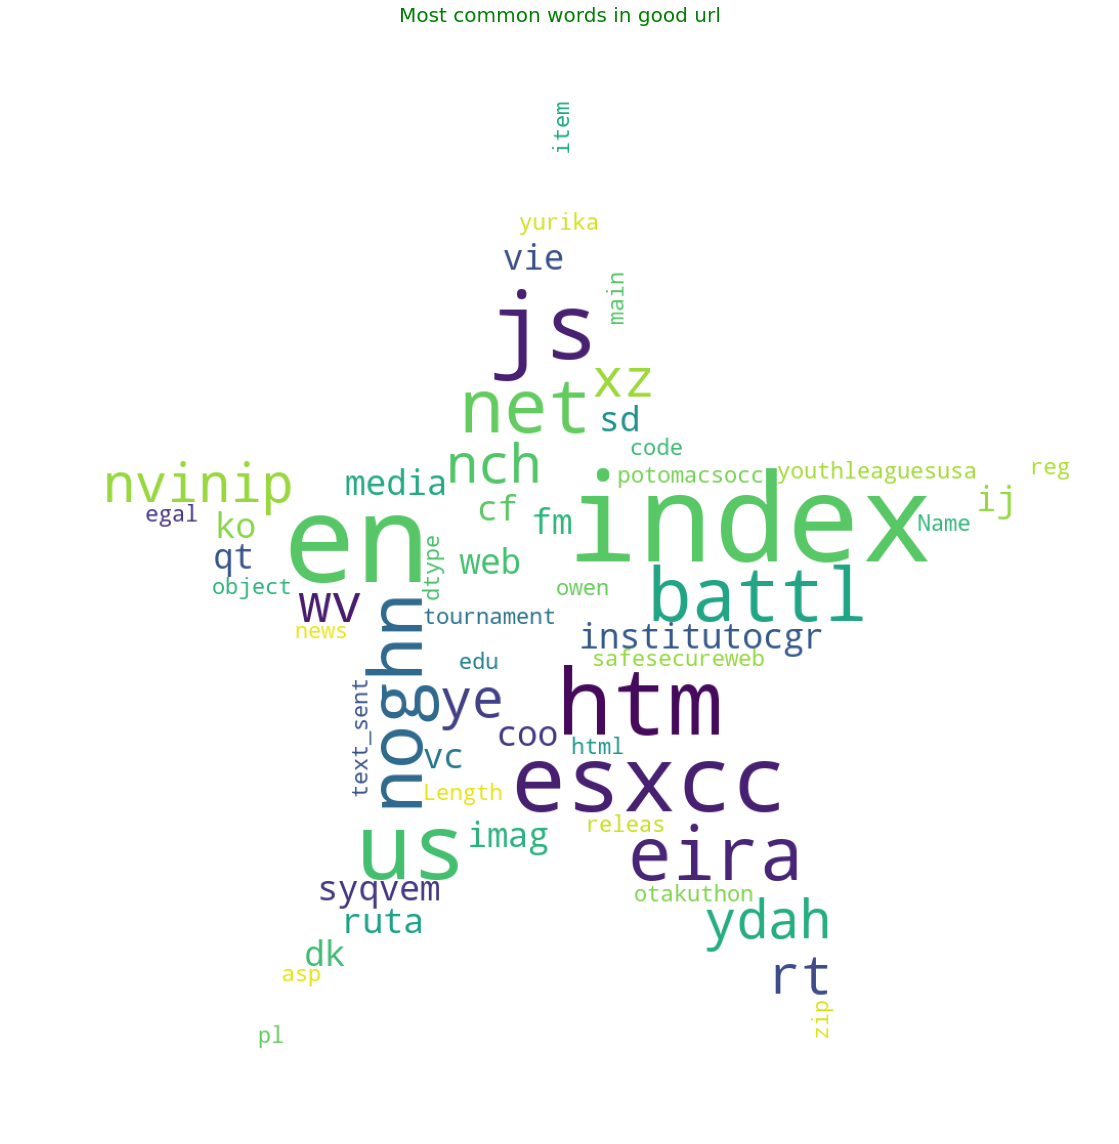

In [45]:
common_text = str(data)
common_mask = np.array(Image.open(d+'star.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
               title='Most common words in good url', title_size=20)

In [47]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

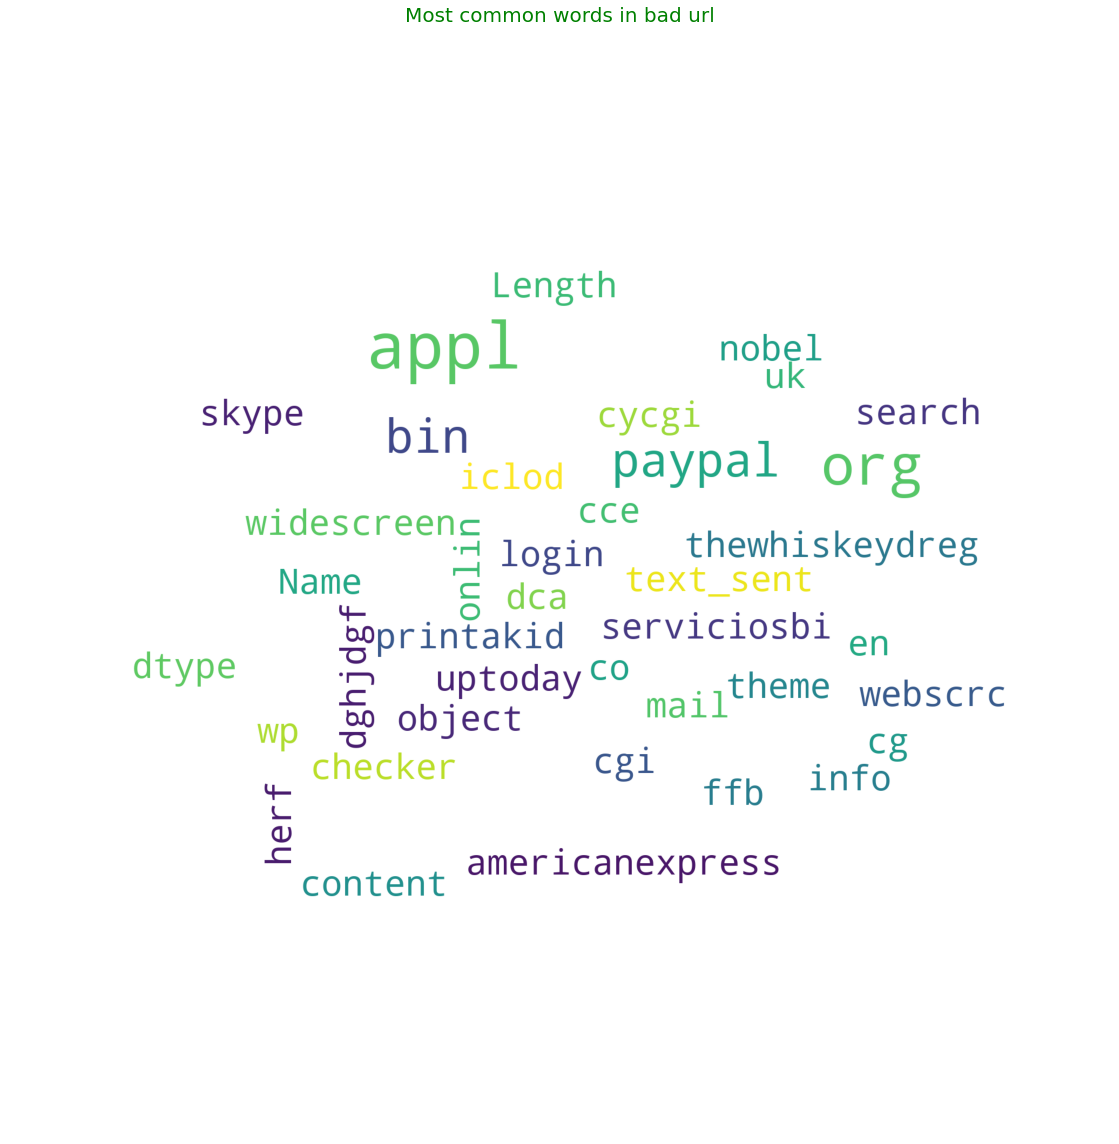

In [49]:
common_text = str(data)
common_mask = np.array(Image.open(d+'comment.png'))
plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
               title='Most common words in bad url', title_size=20)

## Creating Model

### CountVectorizer

CountVectorizer digunakan untuk merubah korpus teks menjadi persearan vektor dari jumlah term/token

In [50]:
cv = CountVectorizer()

In [51]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  --------

In [52]:
feature = cv.fit_transform(phising_data.text_sent) # Merubah semua text dengan tokenisasi dan stemisasi

In [53]:
feature[:5].toarray() # Mengubah sparse matrix menjadi array lalu mencetaknya ke dalam transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [54]:
train_X, test_X, train_y, test_y = train_test_split(feature, phising_data.Label)

### Logistic Regression

Logistic Regression adlaah model klasifikasi machine learning yang digunakan untuk memprediksi probabilitas dari categorical dependent variable. Pada logistic regression, dependent variable adalah variable biner yang mengandung data yang dikodekan sebagai 1 (yes) atau 0 (no). Dengan kata lain, logistic regression memprediksi dengan rumus P(Y=1) sebagai fungsi X

In [55]:
lr = LogisticRegression()

In [56]:
lr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
lr.score(test_X, test_y)

0.9635859236767951

Logistic regression memberikan akurasi 96%

In [58]:
scores_ml = {}
scores_ml['Logistic Regression'] = np.round(lr.score(test_X, test_y), 2)

Training Accuracy: 0.9787019215599659
Testing Accuracy: 0.9635859236767951

Classification Report

              precision    recall  f1-score   support

         Bad       0.90      0.97      0.93     36336
        Good       0.99      0.96      0.97    101001

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.97      0.96      0.96    137337


Confusion Matrix


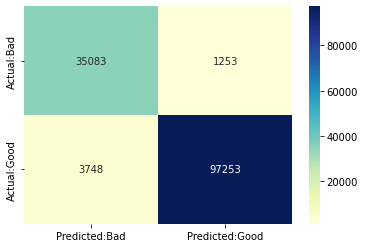

In [59]:
print("Training Accuracy:", lr.score(train_X, train_y))
print("Testing Accuracy:", lr.score(test_X, test_y))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(test_X), test_y),
                       columns = ['Predicted:Bad', 'Predicted:Good'],
                       index = ['Actual:Bad', 'Actual:Good'])

print("\nClassification Report\n")
print(classification_report(lr.predict(test_X), test_y,
                            target_names = ['Bad', 'Good']))

print("\nConfusion Matrix")
plt.figure(figsize=(6,4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='YlGnBu')

### MultinomialNB

Multinomial Naive Bayes pada masalah NLP. Algoritma naive bayes adalah algoritma probabilistik yang berdasarkan implementasi teorema Bayes menggunakan 'naive' assumption dengan kondisi independen antara setiap pasangan feature

In [60]:
mnb = MultinomialNB()

In [61]:
mnb.fit(train_X, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [62]:
mnb.score(test_X, test_y)

0.956981731070287

MultinomialNB give 95% accuracy

In [63]:
scores_ml['MultinomialNB'] = np.round(mnb.score(test_X, test_y), 2)

Training Accuracy: 0.9743573562713436
Testing Accuracy: 0.956981731070287

Classification Report

              precision    recall  f1-score   support

         Bad       0.91      0.93      0.92     37955
        Good       0.97      0.97      0.97     99382

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


Confusion Matrix


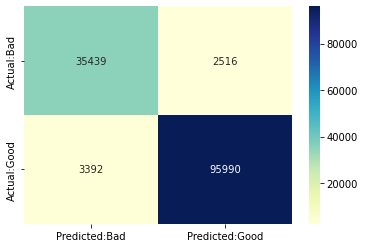

In [64]:
print("Training Accuracy:", mnb.score(train_X, train_y))
print("Testing Accuracy:", mnb.score(test_X, test_y))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(test_X), test_y),
                       columns = ['Predicted:Bad', 'Predicted:Good'],
                       index = ['Actual:Bad', 'Actual:Good'])

print("\nClassification Report\n")
print(classification_report(mnb.predict(test_X), test_y,
                            target_names = ['Bad', 'Good']))

print("\nConfusion Matrix")
plt.figure(figsize=(6,4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='YlGnBu')

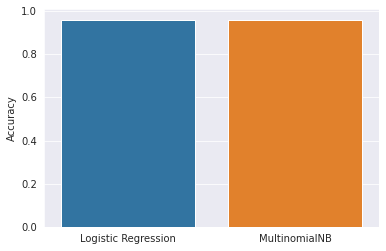

In [65]:
acc = pd.DataFrame.from_dict(scores_ml, orient='index', columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(acc.index, acc.Accuracy)

In fitting, Logistic regression is slightly better than multinomial

### Build pipeline

In [66]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize, stop_words='english'), LogisticRegression())

In [68]:
train_X, test_X, train_y, test_y = train_test_split(phising_data.URL, phising_data.Label)

In [69]:
pipeline_ls.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bo...mpty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)>,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                   

In [70]:
pipeline_ls.score(test_X, test_y)

0.9662363383501896

Training Accuracy: 0.9801630546905529
Testing Accuracy: 0.9662363383501896

Classification Report

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36893
        Good       0.99      0.97      0.98    100444

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


Confusion Matrix


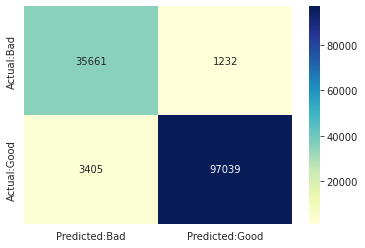

In [71]:
print("Training Accuracy:", pipeline_ls.score(train_X, train_y))
print("Testing Accuracy:", pipeline_ls.score(test_X, test_y))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(test_X), test_y),
                       columns = ['Predicted:Bad', 'Predicted:Good'],
                       index = ['Actual:Bad', 'Actual:Good'])

print("\nClassification Report\n")
print(classification_report(pipeline_ls.predict(test_X), test_y,
                            target_names = ['Bad', 'Good']))

print("\nConfusion Matrix")
plt.figure(figsize=(6,4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap='YlGnBu')

In [72]:
pickle.dump(pipeline_ls, open('phising.pkl', 'wb'))

In [74]:
loaded_model = pickle.load(open('phising.pkl', 'rb'))
result = loaded_model.score(test_X, test_y)
print(result)

0.9662363383501896


## Praktik

Bad links => this are phishing sites yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php fazan-pacir.rs/temp/libraries/ipad www.tubemoviez.exe svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt

Good links => this are not phishing sites www.youtube.com/ youtube.com/watch?v=qI0TQJI3vdU www.retailhellunderground.com/ restorevisioncenters.com/html/technology.html

In [76]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php',
               'fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe', 'retailhellunderground.com/'
               ]
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU',
                'retailhellunderground.com/',
                'restorevisioncenters.com/html/technology.html',
                'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']

loaded_model = pickle.load(open('phising.pkl', 'rb'))

result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)

print(result)
print("="*30)
print(result2)

['bad' 'bad' 'bad' 'good']
['good' 'good' 'good' 'good' 'bad']


## Rekomendasi

Berikut adalah saran untuk perlindungan dari phising

1. Mengaktifkan firewall
2. Melakukan update antivirus
3. Menginstal antispyware
4. Menjaga sistem operasi up to date
5. Berhati-hati ketika downlaod
6. Mematikan komputer